## Задача
Написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).
- problem1-reg_data.csv – данные о времени регистрации
- problem1-auth_data.csv – данные о времени захода пользователей в игру   

В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

## 1. Загрузим данные и посмотрим на них 

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

%matplotlib inline

In [22]:
data_reg = pd.read_csv('/home/jupyter-v.ponomarev-6/shared/problem1-reg_data.csv', sep=';')
data_reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [23]:
data_reg.dtypes

reg_ts    int64
uid       int64
dtype: object

In [24]:
data_auth = pd.read_csv('/home/jupyter-v.ponomarev-6/shared/problem1-auth_data.csv', sep=';')
data_auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [25]:
data_auth.shape

(9601013, 2)

Можно заметить, что объем данных с событиями пользователей относительно большой. Для ускорения вычислений будем работать со случайной подвыборкой в 500 тысяч строк. Исходный массив удалим из памяти

In [26]:
data_auth_sample = data_auth.sample(500000) 

In [27]:
del data_auth #освободим память

Исходные данные времени находятся в формате timestamp. Методом проб было обнаружено, что закодированы секунды.
Преобразуем TimeStamp в удобный для нас формат даты.

In [28]:
data_reg['reg_date'] = pd.to_datetime(pd.to_datetime(data_reg.reg_ts, unit='s').dt.strftime('%m-%d-%Y'))
data_auth_sample['auth_date'] = pd.to_datetime(pd.to_datetime(data_auth_sample.auth_ts, unit='s').dt.strftime('%m-%d-%Y'))

In [29]:
data_auth_sample.dtypes

auth_ts               int64
uid                   int64
auth_date    datetime64[ns]
dtype: object

In [30]:
data_auth_sample.head()

,auth_ts,uid,auth_date
4755974,1564090713,481510,2019-07-25
5137026,1568127317,574075,2019-09-10
8139781,1592240235,387236,2020-06-15
5477111,1571486841,107128,2019-10-19
9134635,1598267196,847852,2020-08-24


## 2. Рассчёт Retention Rate

Теперь у нас есть два массива данных с идентификаторами пользователей, датой их регистрации и событий. Этой информации достаточно, чтобы посчитать Retantion rate.

Основная функция по расчёту Retention rate по дням.   
В исходном массиве находятся данные за значительные промежутки времени. Не имеет смысла рассчитывать Retention на всем объеме данных. Чаще всего интересно посмотреть на события с определенной даты на следующие несколько дней. Для этого в функции предсмотрены два аргумента: один - для задания начальной даты регистрации, второй - для указания количества последующих дней, которые нам интересны.

In [31]:
def retention_rate(events, regs, min_reg_date, next_days, type_ret='raw'):
    """
    events - даты событий
    regs - даты регистраций
    min_reg_date - дата от которой считаем Retention
    next_days - количество последующих дней после даты регистрации для расчёта Retention
    type_ret - тип выходных данных: raw, percentes, both
    """
    max_date = pd.to_datetime(min_reg_date) + pd.DateOffset(days=next_days)
    
    #events left join regs on uid, чтобы иметь дату регистрации и действия в одной строчке
    merged_dates = pd.merge(events, regs[['uid','reg_date']], on='uid', how='left') 
    
    #получаем только исследуемый промежуток времени
    merged_dates = merged_dates.query("reg_date >= @min_reg_date & reg_date <= @max_date & auth_date <= @max_date")\
                               .sort_values(by='reg_date', ascending=True) 
    
    #считаем количество дней между регистрацией и событием
    merged_dates['diff_dates'] = (merged_dates['auth_date'] - merged_dates['reg_date']).dt.days + 1 
    
    #получаем количество пользователей которые вернулись на определенный день в определенную дату
    cohort_data = merged_dates.groupby(['reg_date', 'diff_dates'])['uid'].size().reset_index() 
    
    cohort_table = cohort_data.pivot(index='reg_date', columns='diff_dates', values='uid')
    
    if type_ret == 'raw':
        return cohort_table
    else:
        base_days = cohort_table[1]

        cohort_table_percentes = cohort_table.divide(base_days, axis=0).round(2).mul(100)
        if type_ret == 'percentes':
            return cohort_table_percentes
        elif type_ret == 'both':
            return cohort_table, cohort_table_percentes

Функция для визуализации полученных результатов

In [32]:
def retention_viz(data):
    plt.figure(figsize=(20,14))
    plt.title('Users Active')
    ax = sns.heatmap(data=data, annot=True, vmin=0.0,cmap='Reds')
    ax.set_yticklabels(data.index)
    plt.xlabel('Days since registration')
    plt.ylabel('Registration date')
    #fig=ax.get_figure()
    #fig.savefig("Retention Counts.png")
    plt.show()

## 3. Тестируем функцию для расчёта Retention rate

Вызываем основную функци. Хотим получить сырые и приведенные к процентам значения Retention rate за 15 дней, начиная с 2020-07-01

In [33]:
retantion_absolute, retention_percentes = retention_rate(data_auth_sample, data_reg, '2020-07-01', 15, 'both')
retantion_absolute.fillna('')

diff_dates,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
reg_date,,,,,,,,,,,,,,,,
2020-07-01,79.0,2,4,4,4,3,3,5,1,2,2,2,3,2,3,4
2020-07-02,72.0,2,2,2,2,5,4,1,10,5,2,3,7,3,4,
2020-07-03,78.0,3,2,3,2,4,5,3,3,5,3,1,4,4,,
2020-07-04,74.0,2,8,2,6,9,2,4,1,3,1,3,4,,,
2020-07-05,75.0,1,4,3,4,4,6,4,3,1,6,6,,,,
2020-07-06,77.0,2,3,1,1,8,5,3,3,2,6,,,,,
2020-07-07,81.0,2,1,5,2,2,3,3,4,1,,,,,,
2020-07-08,81.0,3,3,2,3,5,2,5,5,,,,,,,
2020-07-09,94.0,1,4,6,4,5,7,7,,,,,,,,


Визуализация сырых данных

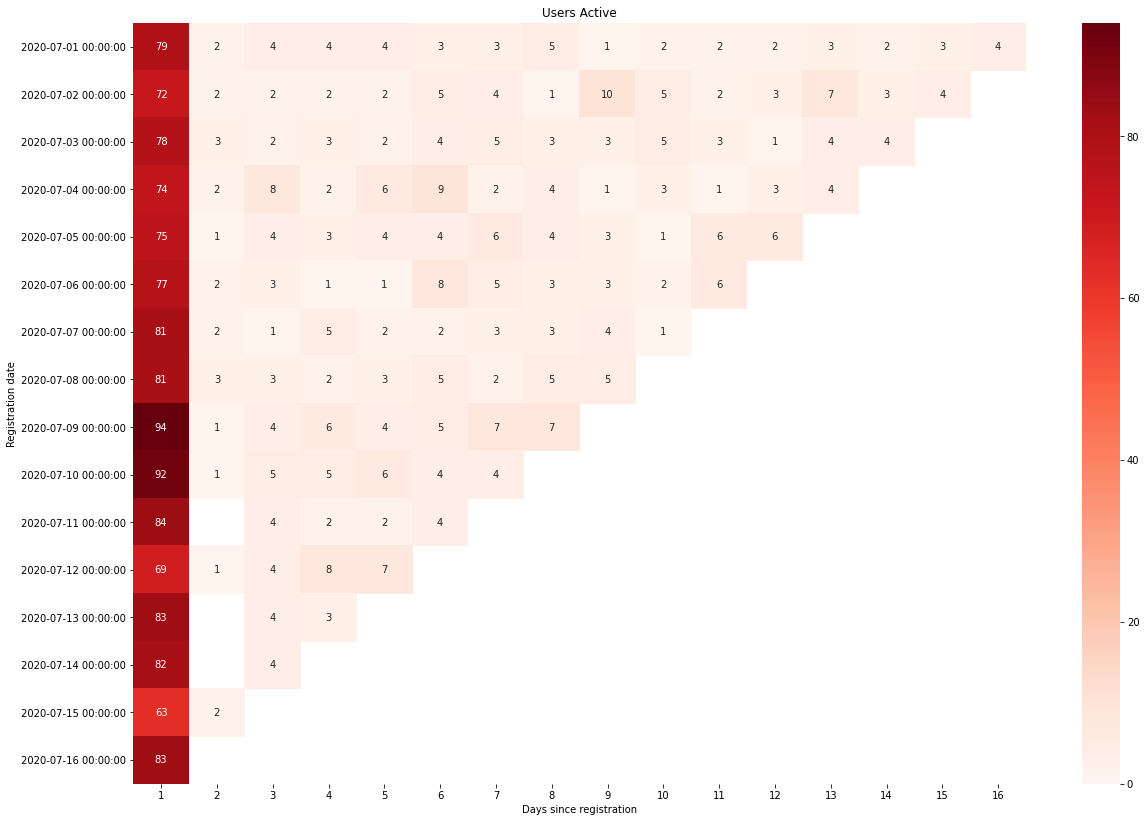

In [34]:
retention_viz(retantion_absolute)

Визуализация Retention Rate

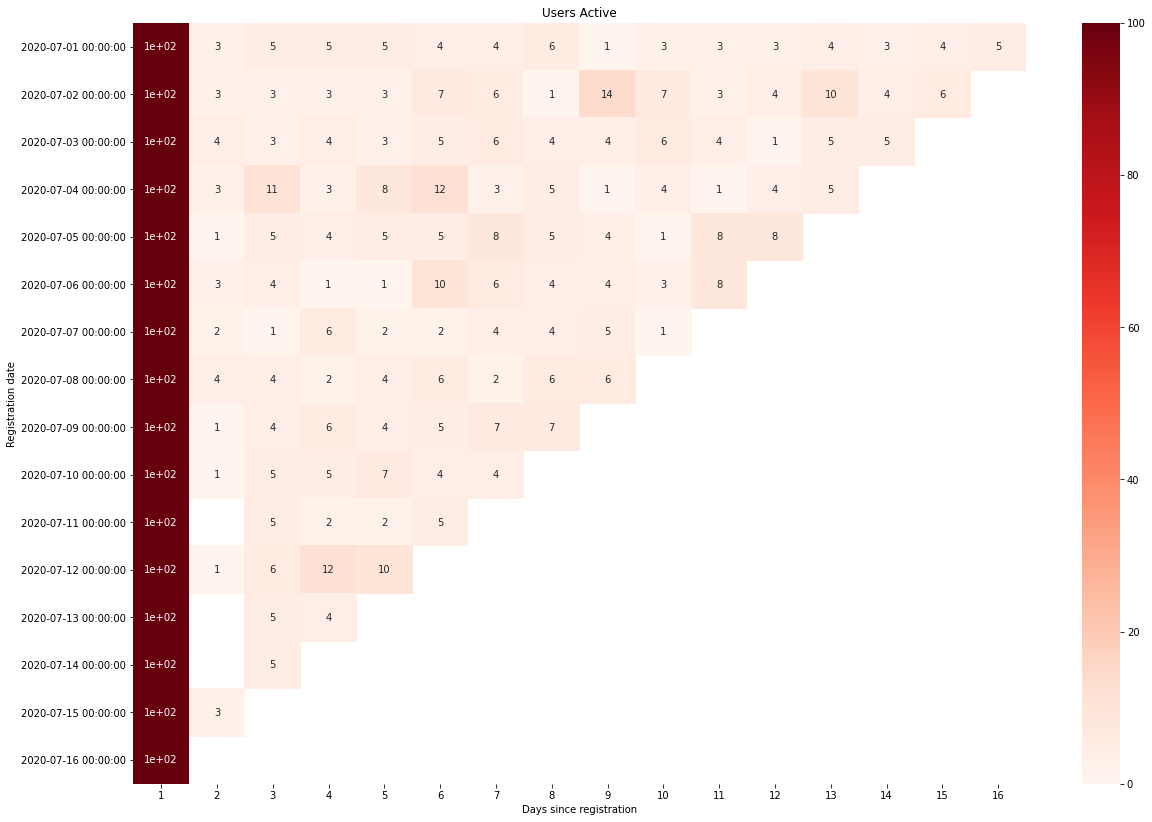

In [35]:
retention_viz(retention_percentes)

Как видим, на частичной выборке пристутствуют пробелы в значениях.
Попробуем загрузить все имеющиеся данные и посмотреть на результат, получится ли восполнить пробелы?

In [36]:
data_auth = pd.read_csv('/home/jupyter-v.ponomarev-6/shared/problem1-auth_data.csv', sep=';')
data_auth['auth_date'] = pd.to_datetime(pd.to_datetime(data_auth.auth_ts, unit='s').dt.strftime('%m-%d-%Y'))
retantion_absolute, retention_percentes = retention_rate(data_auth, data_reg, '2020-07-01', 15, 'both')
retantion_absolute.fillna('')

diff_dates,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
reg_date,,,,,,,,,,,,,,,,
2020-07-01,1432.0,27,66,63,80,89,97,98,70,77,69,67,69,76,66,72
2020-07-02,1434.0,36,57,82,64,97,97,77,89,63,77,71,78,72,63,
2020-07-03,1437.0,30,59,69,73,80,92,96,74,80,78,73,75,84,,
2020-07-04,1439.0,32,72,62,89,92,91,96,72,75,73,69,80,,,
2020-07-05,1441.0,32,61,59,74,94,106,80,70,78,80,90,,,,
2020-07-06,1444.0,29,44,81,81,83,86,87,68,63,60,,,,,
2020-07-07,1446.0,22,56,66,71,92,99,95,68,78,,,,,,
2020-07-08,1449.0,35,63,58,86,72,106,68,68,,,,,,,
2020-07-09,1450.0,28,64,87,63,92,108,104,,,,,,,,


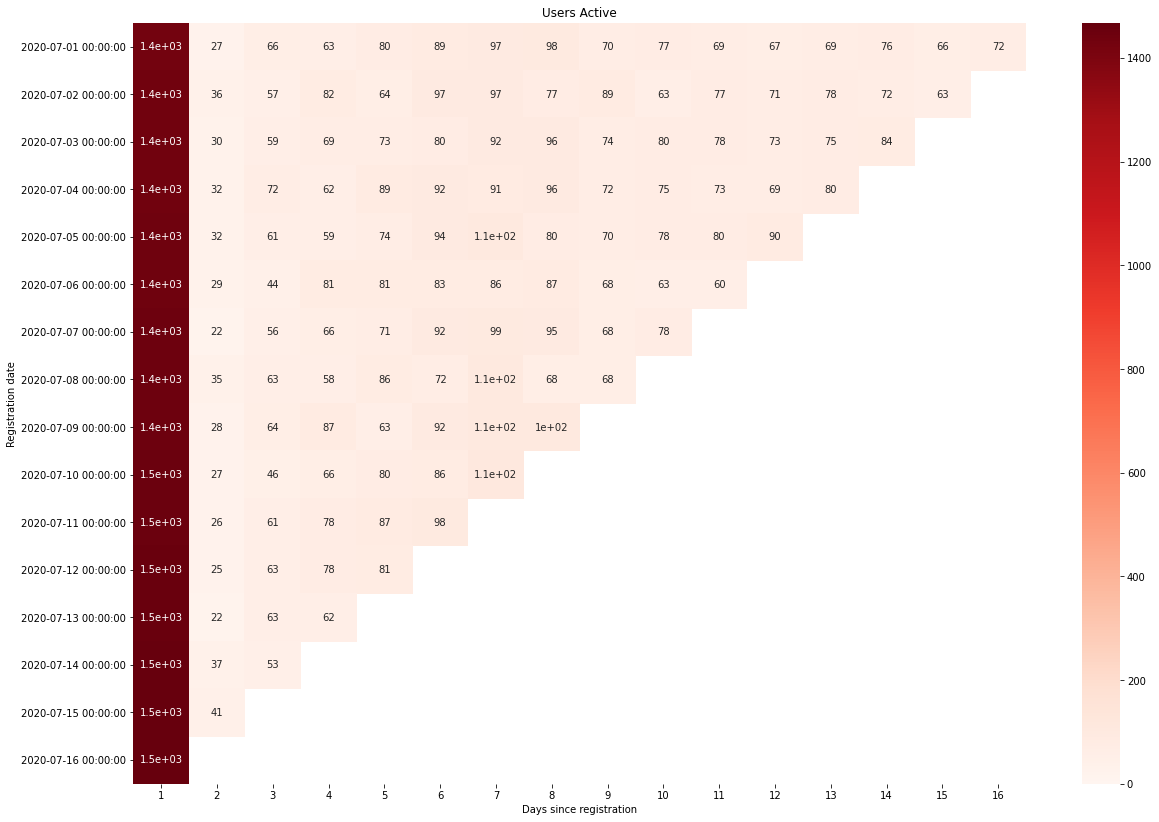

In [37]:
retention_viz(retantion_absolute)

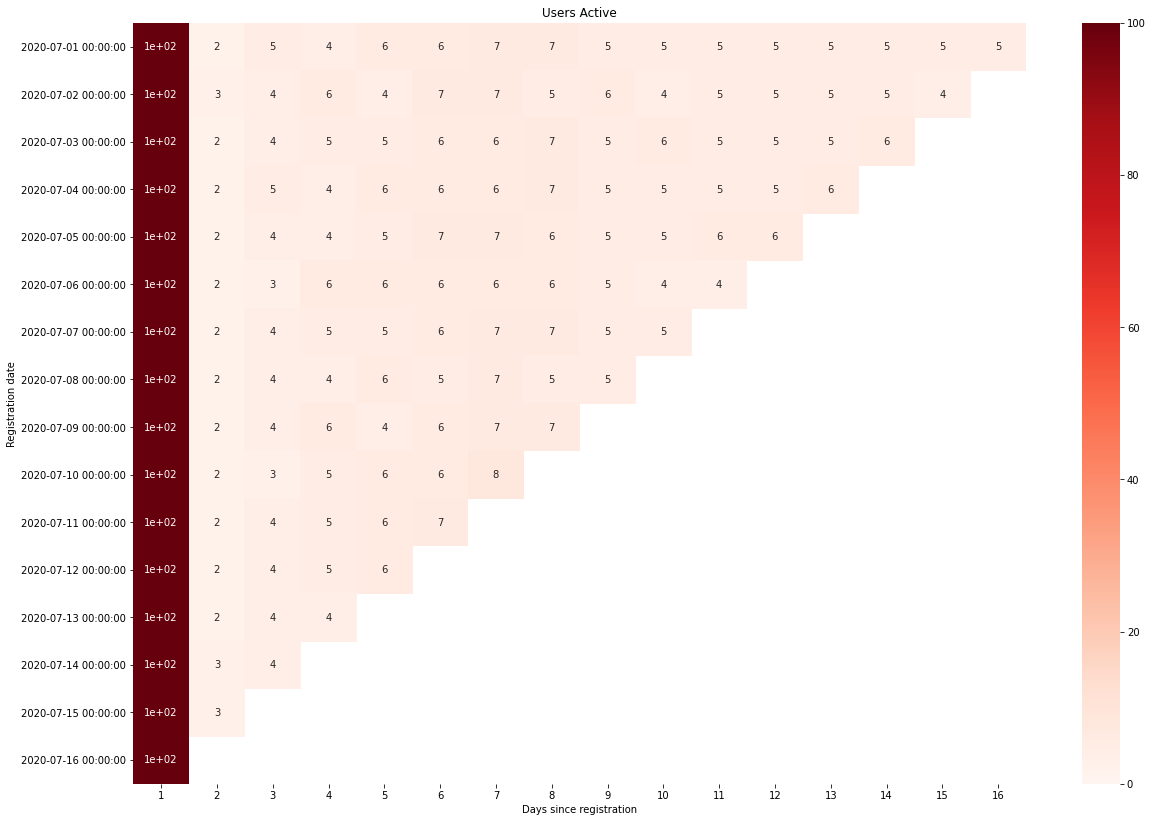

In [38]:
retention_viz(retention_percentes)

Видно, что использование всего массива данных помогло получить полную картину и заполнить пробелы, хотя это и потребовало большее количество ресурсов. Теперь можно с определенной точностью иметь информацию о количестве пользователей в определенные дни после даты их регистрации.
Использую функцию **retention_rate**, можно определять дату регистрации и количество дней, за которые мы хотим посмотреть изменения.